In [35]:
import json
from hashlib import sha256

import geopandas as gpd
import pandas as pd
import numpy as np

from shapely.geometry import shape, point, collection
from shapely import geometry
import fiona
import datetime
pd.set_option("display.max_columns", None)

In [39]:
df = gpd.read_file('NSWFireHistory.json')

In [102]:
#df = df.join(pd.json_normalize(df['properties']))
df2 = df.copy().to_crs({'init': 'epsg:3857'})

/home/james/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [128]:
df2['Area'] = df2['geometry'].area / 10**6
df2['StartDate'] = pd.to_datetime(df2['StartDate'], infer_datetime_format=True)
df2['EndDate'] = pd.to_datetime(df2['EndDate'], infer_datetime_format=True)

df2['Year'] = pd.DatetimeIndex(df['StartDate']).year
df2['Month'] = pd.DatetimeIndex(df['StartDate']).month

df2 = df2[
    (df2['EndDate'].dt.year != 1899) &
    (df2['StartDate'].dt.year != 1899)
]

df2['DurationDays'] = (df2['EndDate'] - df2['StartDate']).dt.days

df2['d_Cause'].replace('', np.nan, inplace=True)
df2.dropna(subset=['d_Cause'], inplace=True)

ValueError: Length of values (34065) does not match length of index (10788)

<AxesSubplot:>

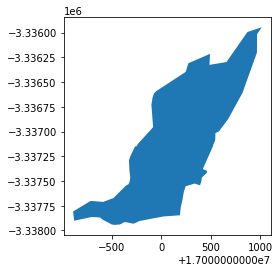

In [77]:
df2[df2['WildFireId'] == 19010222943].plot()

In [126]:
area_by_date_cause = df2.groupby(['d_Cause','Year', 'Month'])['Area'].sum().reset_index()
area_by_date_cause['Date'] = pd.to_datetime([f'{y}-{m}-01' for y, m in zip(area_by_date_cause.Year, area_by_date_cause.Month)])
area_by_date_cause = area_by_date_cause[area_by_date_cause['Year'] > 2000]
area_by_date_cause[['d_Cause', 'Date', 'Area', 'Year']].to_json('data/area_by_date_cause.json', orient='records', date_format='iso')

mean_burnt_area_year = df2.groupby(['d_Cause','Year', 'Month'])['Area'].mean().reset_index()
mean_burnt_area_year['Date'] = pd.to_datetime([f'{y}-{m}-01' for y, m in zip(mean_burnt_area_year.Year, mean_burnt_area_year.Month)])
mean_burnt_area_year = mean_burnt_area_year[mean_burnt_area_year['Year'] > 2000]
mean_burnt_area_year[['Date', 'Area', 'Year', 'd_Cause']].to_json('data/mean_area_burnt_year.json', orient='records', date_format='iso')

area_by_date_cause
mean_burnt_area_year

df2[['WildFireId', 'DurationDays', 'd_Cause', 'Area']].to_json('data/duration_by_fire.json', orient='records', date_format='iso')
    
gapminder = df2.groupby(['Year', 'Month', 'd_Cause'])[['Area', 'DurationDays']].mean().reset_index()
gapminder['Date'] = pd.to_datetime([f'{y}-{m}-01' for y, m in zip(gapminder.Year, gapminder.Month)])
gapminder = gapminder[gapminder['Year'] > 2000]
gapminder[['Year', 'Month', 'Area', 'DurationDays', 'Date', 'd_Cause']].to_json('data/gapminder.json', orient='records', date_format='iso')

area_year = df2.groupby(['Year'])[['Area']].sum().reset_index()
area_year = area_year.round(0)
area_year[['Year', 'Area']].to_json('data/burnt_per_year.json', orient='records', date_format='iso')

In [112]:
df2.sort_values(by='DurationDays', ascending=False).head(1).centroid.to_crs({'init': 'epsg:4326'})

/home/james/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19658    POINT (150.71926 -32.75830)
dtype: geometry

In [130]:
df2['d_Cause'].unique().tolist()

['Accidental',
 'Escaped Hazard Reduction',
 'Undetermined',
 'Escaped Pile Burn',
 'Juvenile (fire play)',
 'Debris Burning',
 'Equipment Use',
 'Lightning',
 'Incendiary',
 'Escaped Permit',
 'Miscellaneous/Other',
 'Rail',
 'Arson',
 'Electrical',
 'Campfire',
 'Natural',
 'Smoking',
 'Suspicious',
 'Machinery/Slasher',
 'Burning Off - Illegal',
 'Motor Vehicle',
 'Power Line',
 'Burning Off - Legal',
 'No Fire']